# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2023-2024 exercise 2

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 28.4.2024

## Initialisation

In [2]:
%matplotlib inline 

In [3]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner

from pytransit import TransitLPF

seterr('ignore')
seed(0)

### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [5]:
tb = Table.read('data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

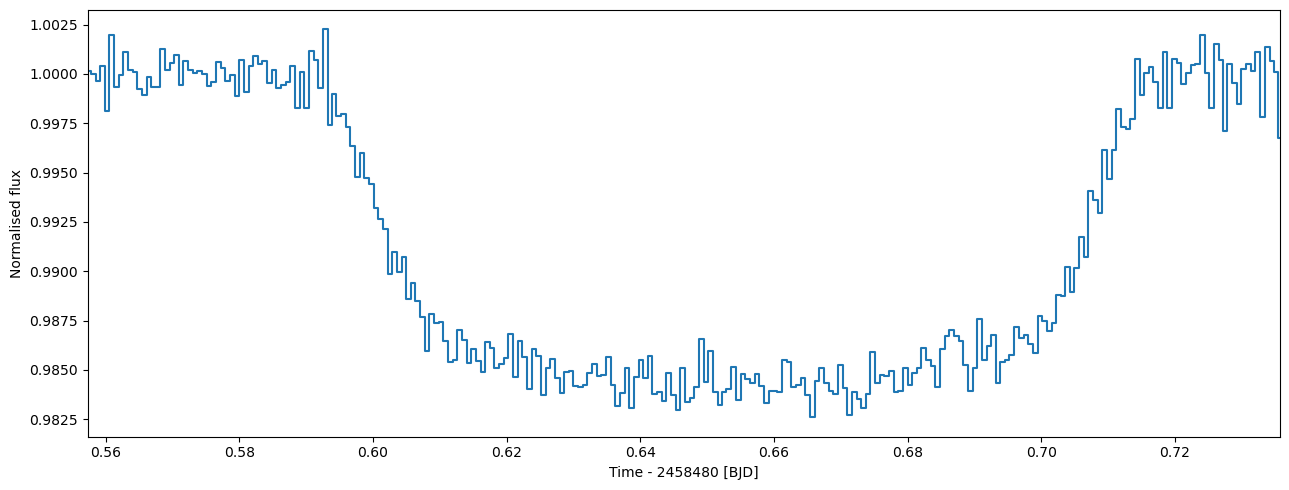

In [7]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [10]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [11]:
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [12]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

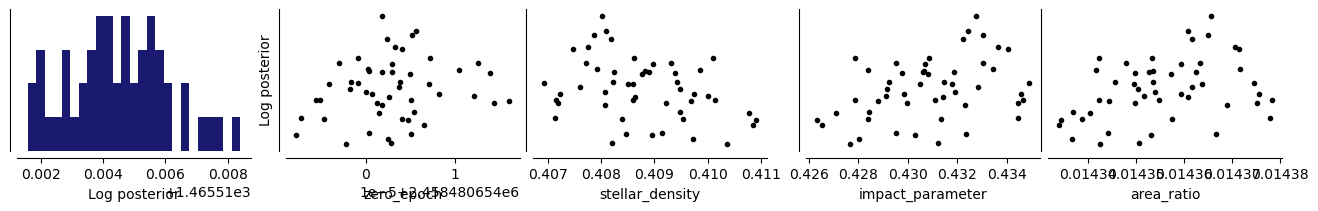

In [13]:
lpf.optimize_global(niter=500, npop=50)

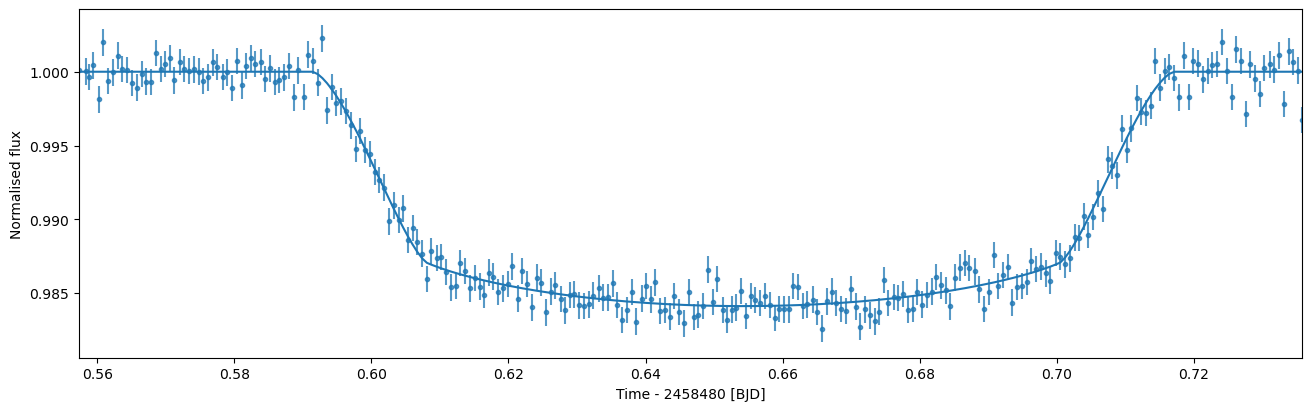

In [14]:
lpf.plot_light_curve();

In [15]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

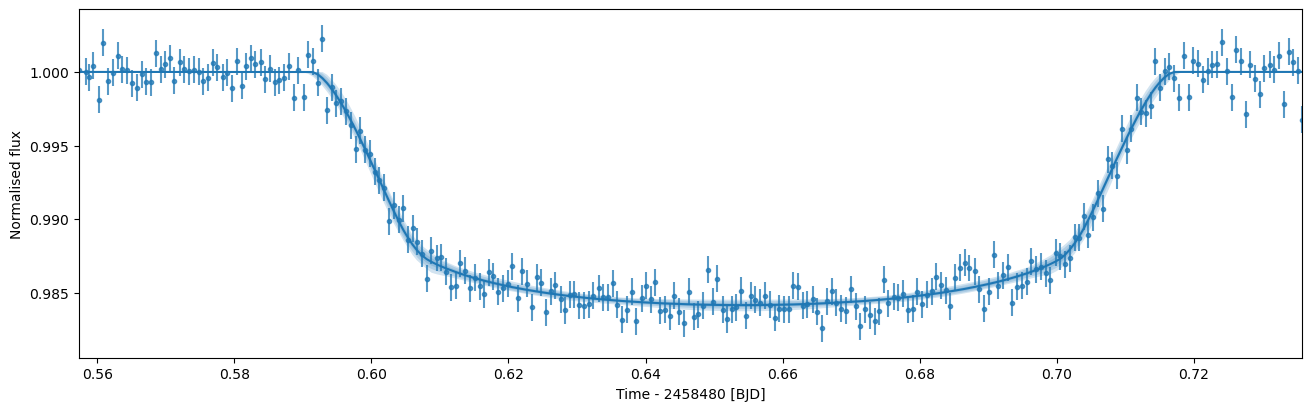

In [16]:
lpf.plot_light_curve('mc');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

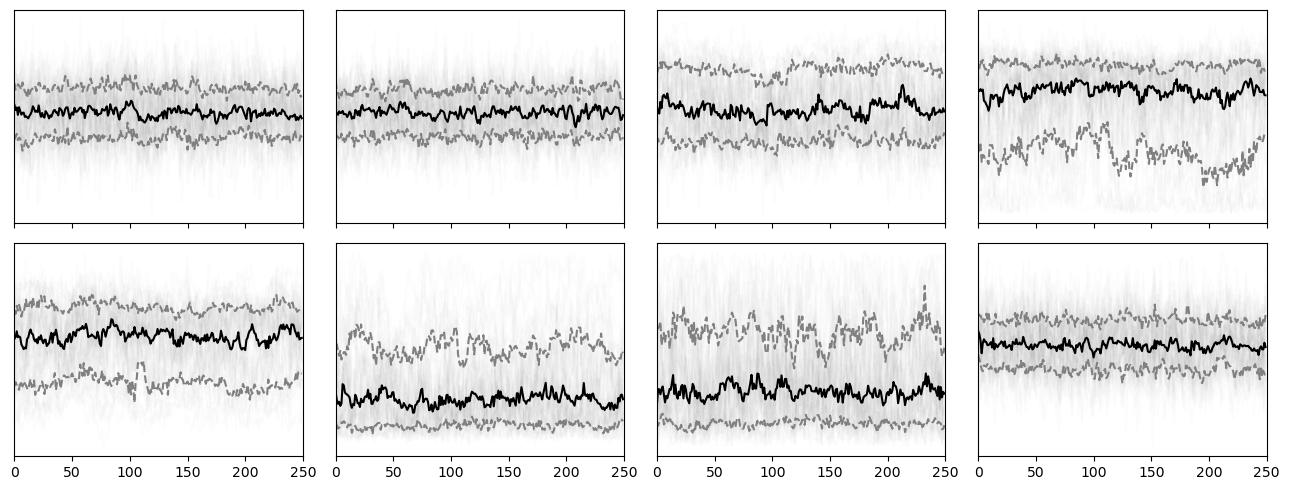

In [18]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [20]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [22]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

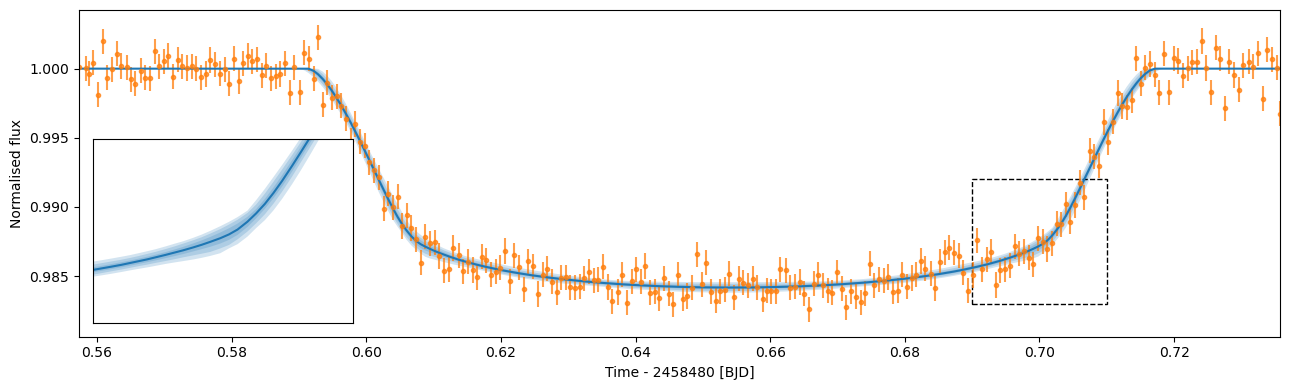

In [23]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()

az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0');

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [27]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4375,3.2475e-01,0.0139,0.3232,0.3399,-3.0407,0.1180,3.0178,1.4617,0.1258,0.0948
std,1.6093e-04,1.1114e-09,0.0368,1.3106e-01,0.0005,0.1995,0.2336,0.0193,0.0020,0.0846,0.0459,0.0009,0.0027
min,2.4585e+06,1.0914e+00,0.3210,1.6912e-05,0.0126,0.0352,0.0001,-3.1174,0.1121,2.7242,1.3578,0.1226,0.0872
25%,2.4585e+06,1.0914e+00,0.4092,2.4968e-01,0.0136,0.1674,0.1529,-3.0542,0.1166,2.9536,1.4269,0.1251,0.0927
50%,2.4585e+06,1.0914e+00,0.4347,3.6450e-01,0.0140,0.2679,0.2808,-3.0412,0.1184,3.0139,1.4496,0.1257,0.0944
75%,2.4585e+06,1.0914e+00,0.4672,4.2362e-01,0.0143,0.4390,0.4791,-3.0276,0.1195,3.0872,1.4898,0.1264,0.0969
max,2.4585e+06,1.0914e+00,0.5333,5.7592e-01,0.0151,0.9963,0.9997,-2.9716,0.1228,3.2264,1.5708,0.1297,0.1012


0.119
0.118
0.1180176


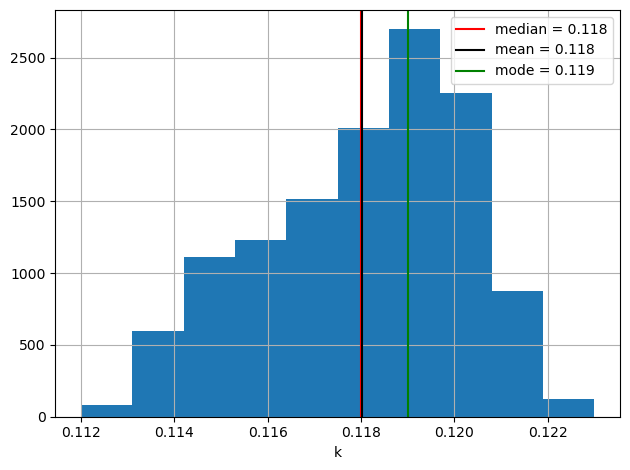

In [128]:
import numpy as np
import statistics as stat

aprox =  np.round(df.k,3)
mode = (stat.mode(np.round(df.k,3)))
median = np.median(aprox)  
mean = np.mean(aprox)

print(mode)
print(median)
print(mean)

fig, ax = subplots()
aprox.hist()
ax.axvline(median, c='r', label =f'median = {median:.3f}')
ax.axvline(mean, c='k', label =f'mean = {mean:.3f}')
ax.axvline(mode, c='g', label =f'mode = {mode:.3f}')

setp(ax, xlabel='k')
ax.legend()
fig.tight_layout()

# for a better aprox we must use mode


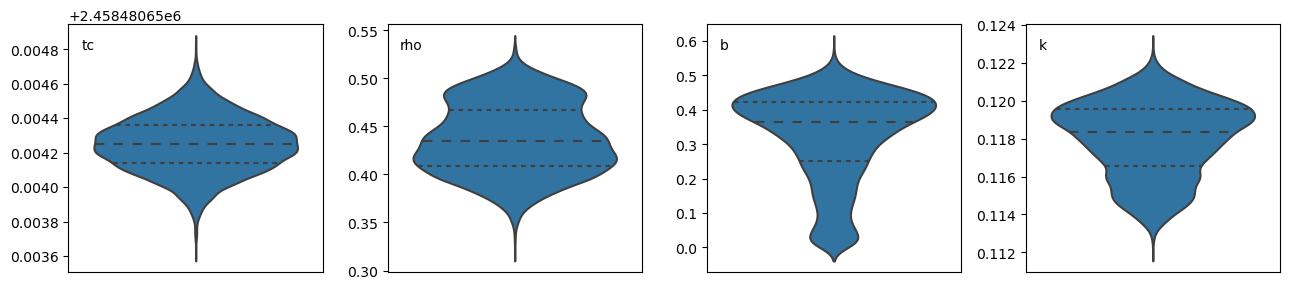

In [35]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

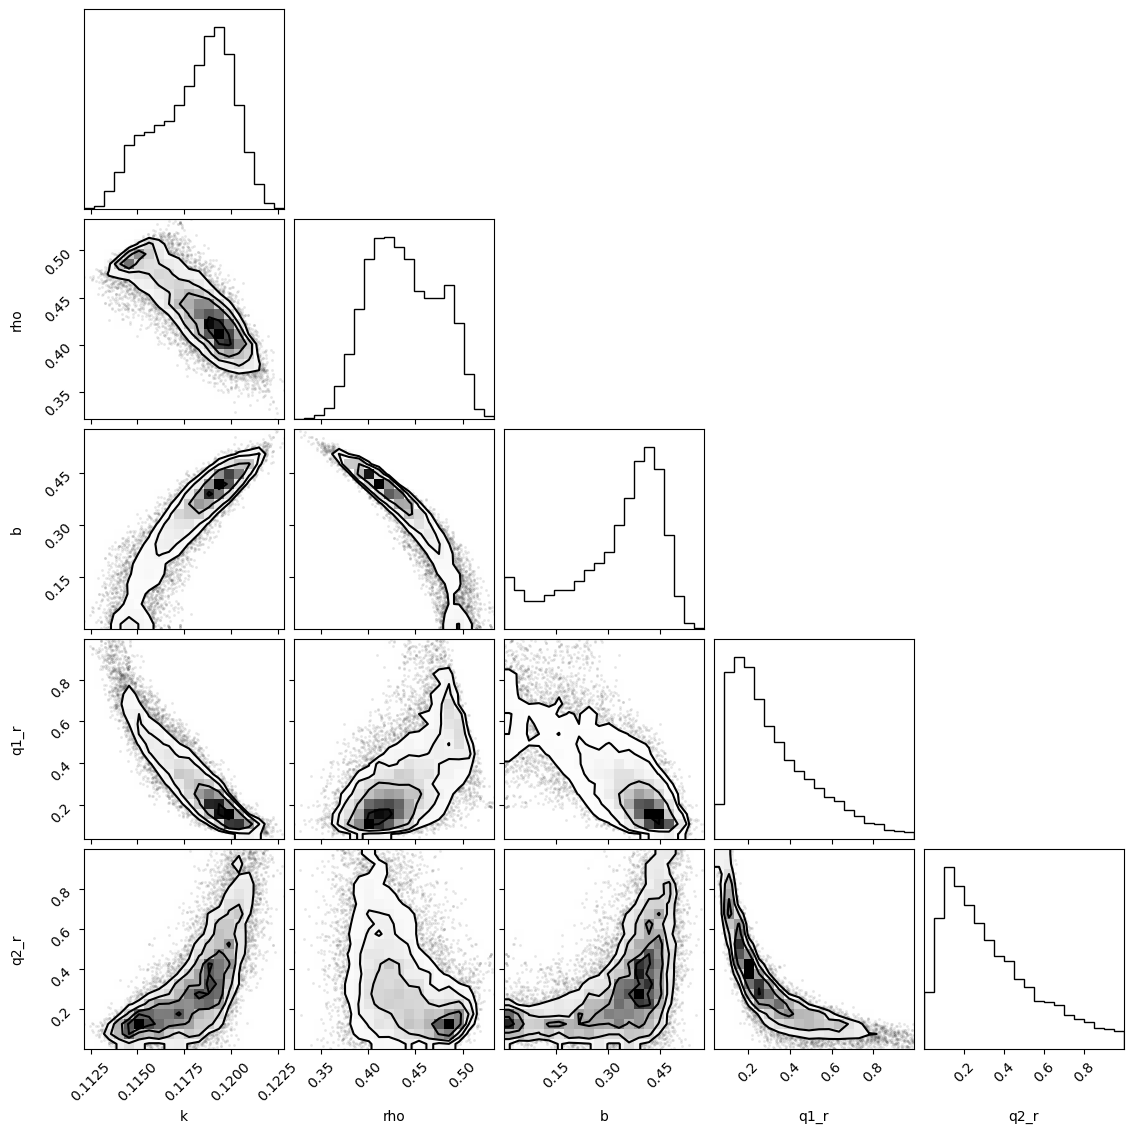

In [37]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols].values, labels=ccols);

### <span style="color:darkblue">Questions and exercises</span>

1. Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere) Give the answer in Jupiter radii.


We have the ratio between planet-star $k = \frac{\mathrm{R_p}}{\mathrm{R_\star}}$, so in order to obtain planet radius we have to multiply by $\mathrm{R_\star}$. As we want in Jupiter radius, it's simple only divide by Jupiter's radius: $$\frac{\mathrm{R_p}}{\mathrm{R_J}} = k \frac{\mathrm{R_\star}}{\mathrm{R_J}}$$, giving a result of: $$\frac{\mathrm{R_p}}{\mathrm{R_J}} = 1.86$$


''The planet is a hot Jupiter with orbital period 1.09 days, mass 1.47 $\mathrm{M_\odot}$ , and radius 1.90  $\mathrm{R_J}$'' https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16#apjlab5c16bib34
It's very similar these two quantities.

In [126]:

import numpy as np

# first we define all the variable
R_sun = 6.96 * pow(10,5) #km wikipedia
R_J = 69911 #km, Volumetric mean radius (km),     https://nssdc.gsfc.nasa.gov/planetary/factsheet/jupiterfact.htm     
k = mode
print(k)
r_star = 1.57 * R_sun  #km, wikipedia


def planet_mass_jupiter(k, r_star, R_J):
    ratio = k * r_star / R_J
    return ratio

ratio = planet_mass_jupiter(k, r_star, R_J)
print(f"Radius of plantet in terms of planet Jupiter is: {ratio:.2f}")

0.119
Radius of plantet in terms of planet Jupiter is: 1.86


2. Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.

- Answer. There is to ways of achive this excersice goal: serching for the mean density value $\mathrm{\rho_{mean}} = 0.46 \frac{g}{cm^3}$ or assuming correct the mass and radius given by wikipedia and doing the mean density value $\mathrm{\rho_{wiki}} = \frac{M}{V}$ (asume sphere volume). Once we calculate the value we can compare with mean model value, giving (see code below): $$\mathrm{\rho_{wiki}} = 0.49 \frac{g}{cm^3}$$  $$\mathrm{\rho_{model}} = 0.4372 \frac{g}{cm^3}$$   $$\frac{\mathrm{\rho_{model}}}{\mathrm{\rho_{mean}}} = 0.95$$   $$\frac{\mathrm{\rho_{model}}}{\mathrm{\rho_{wiki}}} = 0.89$$

3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?

- Answer. In the plots described above we can see the different correlations between the parameters of the transit method. Mathematically these plots are the intersections of the histograms of 2 parameters, in which for the shift of one of these the best value of the remaining variable is calculated. In some of these plots we can observe more than one densely populated region, being this behaviour expected as their histograms can be decomposed into the contribution of 2 normal distributions. 



### <span style="color:red">Question 2 code</span>


In [83]:
import numpy as np

rho_th = 0.46 # g / cm^3

R_sun_cm = 6.96 * pow(10,10) # cm wikipedia
M_sun_g = 1.98 * pow(10,33) # g wikipedia
m_star = 1.35 * M_sun_g
r_star = 1.57 * R_sun_cm

def density(a,b):
    dens = ( (3 * a) / (4 * np.pi * pow(b,3)) )
    return dens

rho_wiki = density(m_star, r_star)


print(f"Density of WASP12 assuming sphere volume, wikipedia, is: {rho_wiki:.2f} g/cm^3")

rho_model = df.describe()['rho']['mean']
rho_rate_1 =  rho_model / rho_th
rho_rate_2 =  rho_model / rho_wiki

print(f"Density rate of WASP12 assuming article density is: {rho_rate_1:.2f} ")
print(f"Density rate of WASP12 assuming sphere volume, wikipedia, is: {rho_rate_2:.2f} ")


Density of WASP12 assuming sphere volume, wikipedia, is: 0.49 g/cm^3
Density rate of WASP12 assuming article density is: 0.95 
Density rate of WASP12 assuming sphere volume, wikipedia, is: 0.89 


---
<center>&copy;2024 Hannu Parviainen</center>